In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# ==========================================
# 1. Load Datasets
# ==========================================
# Load your existing training data (Old Data)
# Make sure this path points to the file you created in your previous code
train_df = pd.read_csv(r"C:\Users\kavee\Downloads\codemerged_dataset.csv")

# Load the new dataset (New Data)
# Update this path to where you saved the new file
new_df = pd.read_csv(r"C:\Users\kavee\Downloads\Water Quality Testing.csv")

print(f"Old Data Shape: {train_df.shape}")
print(f"New Data Shape: {new_df.shape}")

# ==========================================
# 2. Align Columns (Rename New to match Old)
# ==========================================
new_df_renamed = new_df.rename(columns={
    "Dissolved Oxygen (mg/L)": "DO",
    "Conductivity (µS/cm)": "Conductivity",
    "Turbidity (NTU)": "Turbidity"
    # 'pH' is already named 'pH'
})

# Define the Common Features we can use
COMMON_FEATURES = ["pH", "DO", "Conductivity", "Turbidity"]

print(f"\nTraining with Common Features: {COMMON_FEATURES}")

# ==========================================
# 3. Prepare Data for Training
# ==========================================
# Select only common features and the target
X_train = train_df[COMMON_FEATURES]
y_train = train_df["Potability"]

# Select common features from new data
X_new = new_df_renamed[COMMON_FEATURES]

# Handle any remaining missing values
# (We use a fresh imputer to ensure new data is treated exactly like training data)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_new_imputed = imputer.transform(X_new)

# ==========================================
# 4. Train Model (on Old Data)
# ==========================================
print("Training Random Forest on compatible features...")
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train_imputed, y_train)

# ==========================================
# 5. Predict on New Data
# ==========================================
print("Predicting on new data...")
predictions = model.predict(X_new_imputed)
probabilities = model.predict_proba(X_new_imputed)[:, 1]

# Add results back to the original new dataframe
new_df["Predicted_Potability"] = predictions
new_df["Safety_Probability"] = probabilities
new_df["Status"] = new_df["Predicted_Potability"].map({1: "Safe", 0: "Unsafe"})

# ==========================================
# 6. Save Results
# ==========================================
output_path = r"C:\Users\kavee\Downloads\New_Data_Predictions.csv"
new_df.to_csv(output_path, index=False)

print("\nSuccess! Predictions saved to:", output_path)
print(new_df[["Sample ID", "Status", "Safety_Probability"]].head(10))

Old Data Shape: (12647, 8)
New Data Shape: (500, 6)

Training with Common Features: ['pH', 'DO', 'Conductivity', 'Turbidity']
Training Random Forest on compatible features...
Predicting on new data...

Success! Predictions saved to: C:\Users\kavee\Downloads\New_Data_Predictions.csv
   Sample ID  Status  Safety_Probability
0          1  Unsafe            0.440000
1          2  Unsafe            0.190000
2          3  Unsafe            0.100000
3          4  Unsafe            0.103333
4          5  Unsafe            0.340000
5          6  Unsafe            0.326667
6          7  Unsafe            0.046667
7          8  Unsafe            0.420000
8          9  Unsafe            0.103333
9         10    Safe            0.520000


test:- csv file Water_Quality_Dataset.csv

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==========================================
# 1. SETUP & LOADING
# ==========================================
# PATHS - Update these to your actual file locations
TRAIN_DATA_PATH = r"C:\Users\kavee\Downloads\codemerged_dataset.csv"
NEW_DATA_PATH   = r"C:\Users\kavee\Downloads\Water Quality Testing.csv"
OUTPUT_PATH     = r"C:\Users\kavee\Downloads\New_Data_Predictions.csv"

# Load Datasets
print("Loading datasets...")
df_train = pd.read_csv(TRAIN_DATA_PATH)
df_new = pd.read_csv(NEW_DATA_PATH)

# ==========================================
# 2. ALIGN COLUMNS & FEATURES
# ==========================================
# Rename columns in New Data to match the Training Data
df_new = df_new.rename(columns={
    "Dissolved Oxygen (mg/L)": "DO",
    "Conductivity (µS/cm)": "Conductivity",
    "Turbidity (NTU)": "Turbidity"
    # 'pH' is already 'pH'
})

# Identify common features
train_features = set(df_train.columns)
new_features = set(df_new.columns)

# We want features that exist in BOTH, excluding ID or Target columns
common_features = list(train_features.intersection(new_features))
if "Sample ID" in common_features: common_features.remove("Sample ID")
if "Potability" in common_features: common_features.remove("Potability")

print(f"\nCommon Features found: {common_features}")
print(f"Ignored features (not in both): {list(train_features.symmetric_difference(new_features) - {'Potability', 'Sample ID'})}")

# ==========================================
# 3. PREPARE TRAINING DATA (With Leakage Fix)
# ==========================================
X = df_train[common_features]
y = df_train["Potability"]

# 🛑 FIX: Split BEFORE Imputation to prevent Data Leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize Imputer
imputer = KNNImputer(n_neighbors=5)

# Fit on TRAIN only, then transform TRAIN and TEST
print("\nImputing missing values (Fit on Train, Transform on Test)...")
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=common_features)
X_test_imputed  = pd.DataFrame(imputer.transform(X_test), columns=common_features)

# ==========================================
# 4. TRAIN MODEL
# ==========================================
print("Training Random Forest...")
model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    min_samples_split=5  # Slight regularization
)
model.fit(X_train_imputed, y_train)

# ==========================================
# 5. EVALUATE ACCURACY (On Held-Out Data)
# ==========================================
y_pred_test = model.predict(X_test_imputed)
acc = accuracy_score(y_test, y_pred_test)

print("-" * 30)
print(f"✅ Model Accuracy (using only common features): {acc:.4f}")
print("-" * 30)
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred_test))

# ==========================================
# 6. PROCESS NEW DATA
# ==========================================
print("Processing new data...")
X_new = df_new[common_features]

# Impute new data using the SAME imputer fitted on training data
X_new_imputed = pd.DataFrame(imputer.transform(X_new), columns=common_features)

# Predict
predictions = model.predict(X_new_imputed)
probs = model.predict_proba(X_new_imputed)[:, 1]

# Save Results
df_new["Predicted_Potability"] = predictions
df_new["Safety_Probability"] = probs
df_new["Status"] = df_new["Predicted_Potability"].map({1: "Safe", 0: "Unsafe"})

df_new.to_csv(OUTPUT_PATH, index=False)
print(f"\n🚀 Predictions saved to: {OUTPUT_PATH}")
print(df_new[["Sample ID", "Status", "Safety_Probability"]].head())

Loading datasets...

Common Features found: ['pH', 'Conductivity', 'Turbidity', 'DO']
Ignored features (not in both): ['Nitrate', 'BOD', 'Fecal_Coliform', 'Temperature (°C)']

Imputing missing values (Fit on Train, Transform on Test)...
Training Random Forest...
------------------------------
✅ Model Accuracy (using only common features): 0.8427
------------------------------

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      1873
           1       0.81      0.51      0.63       657

    accuracy                           0.84      2530
   macro avg       0.83      0.74      0.76      2530
weighted avg       0.84      0.84      0.83      2530

Processing new data...

🚀 Predictions saved to: C:\Users\kavee\Downloads\New_Data_Predictions.csv
   Sample ID  Status  Safety_Probability
0          1  Unsafe            0.358581
1          2  Unsafe            0.161661
2          3  Unsafe            0.075

Loading datasets...

Common Features found: ['pH', 'Conductivity', 'Turbidity', 'DO']

Imputing missing values...
Training Random Forest...

📊 MODEL PERFORMANCE REPORT
✅ Overall Accuracy: 84.27%
----------------------------------------

📋 Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1873
           1       0.81      0.51      0.63       657

    accuracy                           0.84      2530
   macro avg       0.83      0.74      0.76      2530
weighted avg       0.84      0.84      0.83      2530



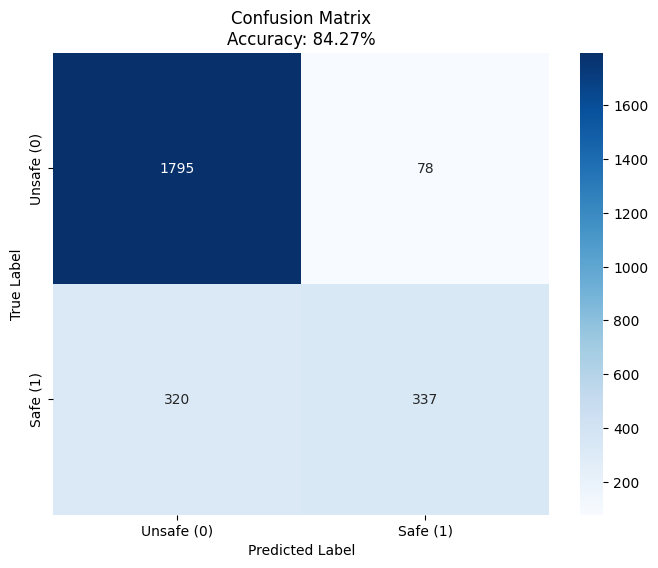


Processing new data predictions...

📝 NEW DATA PREDICTIONS (Top 10)
   Sample ID  Status  Safety_Probability
0          1  Unsafe            0.358581
1          2  Unsafe            0.161661
2          3  Unsafe            0.075873
3          4  Unsafe            0.111639
4          5  Unsafe            0.275762
5          6  Unsafe            0.407045
6          7  Unsafe            0.032500
7          8  Unsafe            0.456251
8          9  Unsafe            0.117107
9         10  Unsafe            0.210456

🚀 Full results saved to: C:\Users\kavee\Downloads\New_Data_Predictions.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==========================================
# 1. SETUP & LOADING
# ==========================================
# PATHS - Update these to your actual file locations
TRAIN_DATA_PATH = r"C:\Users\kavee\Downloads\codemerged_dataset.csv"
NEW_DATA_PATH   = r"C:\Users\kavee\Downloads\Water Quality Testing.csv"
OUTPUT_PATH     = r"C:\Users\kavee\Downloads\New_Data_Predictions.csv"

# Load Datasets
print("Loading datasets...")
try:
    df_train = pd.read_csv(TRAIN_DATA_PATH)
    df_new = pd.read_csv(NEW_DATA_PATH)
except FileNotFoundError as e:
    print(f"Error: Could not find the file. Please check the paths. {e}")
    exit()

# ==========================================
# 2. ALIGN COLUMNS & FEATURES
# ==========================================
# Rename columns in New Data to match the Training Data
df_new = df_new.rename(columns={
    "Dissolved Oxygen (mg/L)": "DO",
    "Conductivity (µS/cm)": "Conductivity",
    "Turbidity (NTU)": "Turbidity"
    # 'pH' is already 'pH'
})

# Identify common features
train_features = set(df_train.columns)
new_features = set(df_new.columns)

# We want features that exist in BOTH, excluding ID or Target columns
common_features = list(train_features.intersection(new_features))
if "Sample ID" in common_features: common_features.remove("Sample ID")
if "Potability" in common_features: common_features.remove("Potability")

print(f"\nCommon Features found: {common_features}")

# ==========================================
# 3. PREPARE TRAINING DATA
# ==========================================
X = df_train[common_features]
y = df_train["Potability"]

# Split BEFORE Imputation to prevent Data Leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize Imputer
imputer = KNNImputer(n_neighbors=5)

# Fit on TRAIN only, then transform TRAIN and TEST
print("\nImputing missing values...")
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=common_features)
X_test_imputed  = pd.DataFrame(imputer.transform(X_test), columns=common_features)

# ==========================================
# 4. TRAIN MODEL
# ==========================================
print("Training Random Forest...")
model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    min_samples_split=5 
)
model.fit(X_train_imputed, y_train)

# ==========================================
# 5. EVALUATE & CONFUSION MATRIX
# ==========================================
y_pred_test = model.predict(X_test_imputed)
acc = accuracy_score(y_test, y_pred_test)

print("\n" + "="*40)
print(f"📊 MODEL PERFORMANCE REPORT")
print("="*40)
print(f"✅ Overall Accuracy: {acc:.2%}")
print("-" * 40)
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred_test))

# --- GENERATE CONFUSION MATRIX ---
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Unsafe (0)', 'Safe (1)'], 
            yticklabels=['Unsafe (0)', 'Safe (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix\nAccuracy: {acc:.2%}')
plt.show()

# ==========================================
# 6. PROCESS NEW DATA & RESULTS TABLE
# ==========================================
print("\nProcessing new data predictions...")
X_new = df_new[common_features]
X_new_imputed = pd.DataFrame(imputer.transform(X_new), columns=common_features)

# Predict
df_new["Predicted_Potability"] = model.predict(X_new_imputed)
df_new["Safety_Probability"] = model.predict_proba(X_new_imputed)[:, 1]
df_new["Status"] = df_new["Predicted_Potability"].map({1: "Safe", 0: "Unsafe"})

# Displaying the Results Table
print("\n" + "="*40)
print("📝 NEW DATA PREDICTIONS (Top 10)")
print("="*40)
# Showing specific columns for clarity
print(df_new[["Sample ID", "Status", "Safety_Probability"]].head(10))

# Save Results
df_new.to_csv(OUTPUT_PATH, index=False)
print(f"\n🚀 Full results saved to: {OUTPUT_PATH}")

Test data:-Water Quality Testing.csv

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report

# ==========================================
# 1. SETUP PATHS
# ==========================================
# Update these paths to match your actual file locations
TRAIN_DATA_PATH = r"C:\Users\kavee\Downloads\codemerged_dataset.csv" 
NEW_DATA_PATH   = r"C:\Users\kavee\Downloads\Water Quality Testing.csv"
OUTPUT_PATH     = r"C:\Users\kavee\Downloads\New_Data_Predictions.csv"

# Load Datasets
print("Loading datasets...")
try:
    df_train = pd.read_csv(TRAIN_DATA_PATH)
    df_new = pd.read_csv(NEW_DATA_PATH)
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please check the file paths in the code.")
    exit()

# ==========================================
# 2. ALIGN FEATURES
# ==========================================
# Map the new dataset's column names to match the training dataset
column_mapping = {
    "Dissolved Oxygen (mg/L)": "DO",
    "Conductivity (µS/cm)": "Conductivity",
    "Turbidity (NTU)": "Turbidity",
    "Temperature (°C)": "Temperature" # This might not be in training data, but good to rename
}
df_new = df_new.rename(columns=column_mapping)

# Find features that exist in BOTH datasets
train_cols = set(df_train.columns)
new_cols = set(df_new.columns)

# We only want features used for prediction (exclude ID and Target)
exclude_cols = {"Sample ID", "Potability", "Status"}
common_features = list((train_cols.intersection(new_cols)) - exclude_cols)

print(f"\nTraining Model using ONLY these compatible features: {common_features}")
print(f"Ignored features (missing in one dataset): {list((train_cols ^ new_cols) - exclude_cols)}")

# ==========================================
# 3. PREPARE & SPLIT DATA
# ==========================================
X = df_train[common_features]
y = df_train["Potability"]

# Clean new data (ensure it's numeric)
X_new_raw = df_new[common_features]
for col in common_features:
    X_new_raw[col] = pd.to_numeric(X_new_raw[col], errors='coerce')

# Split Training Data (Train vs Validation)
# We split BEFORE imputing to prevent data leakage
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================
# 4. IMPUTATION (Fill Missing Values)
# ==========================================
print("\nImputing missing values...")
imputer = KNNImputer(n_neighbors=5)

# Fit imputer on Training data ONLY
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=common_features)

# Apply the same imputer to Validation and New Data
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=common_features)
X_new_imputed = pd.DataFrame(imputer.transform(X_new_raw), columns=common_features)

# ==========================================
# 5. TRAIN & TEST MODEL
# ==========================================
print("Training Random Forest...")
model = RandomForestClassifier(n_estimators=300, random_state=42, min_samples_split=5)
model.fit(X_train_imputed, y_train)

# Evaluate on Validation Set
y_val_pred = model.predict(X_val_imputed)
acc = accuracy_score(y_val, y_val_pred)

print("-" * 40)
print(f"✅ Model Validation Accuracy: {acc:.4f}")
print("This is the expected accuracy on new data given the limited features.")
print("-" * 40)

# ==========================================
# 6. PREDICT ON NEW DATA
# ==========================================
print("Generating predictions for new data...")
predictions = model.predict(X_new_imputed)
probabilities = model.predict_proba(X_new_imputed)[:, 1]

# Save results
df_new["Predicted_Potability"] = predictions
df_new["Safety_Score"] = probabilities
df_new["Status"] = df_new["Predicted_Potability"].map({1: "Safe", 0: "Unsafe"})

# Save to CSV
df_new.to_csv(OUTPUT_PATH, index=False)
print(f"\n🚀 Success! Predictions saved to: {OUTPUT_PATH}")
print(df_new[["Sample ID", "Status", "Safety_Score"]].head(10))

Loading datasets...

Training Model using ONLY these compatible features: ['DO', 'Conductivity', 'Turbidity', 'pH']
Ignored features (missing in one dataset): ['Temperature', 'Nitrate', 'BOD', 'Fecal_Coliform']

Imputing missing values...
Training Random Forest...


C:\Users\kavee\AppData\Local\Temp\ipykernel_26960\2749974524.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new_raw[col] = pd.to_numeric(X_new_raw[col], errors='coerce')


----------------------------------------
✅ Model Validation Accuracy: 0.8399
This is the expected accuracy on new data given the limited features.
----------------------------------------
Generating predictions for new data...

🚀 Success! Predictions saved to: C:\Users\kavee\Downloads\New_Data_Predictions.csv
   Sample ID  Status  Safety_Score
0          1  Unsafe      0.336806
1          2  Unsafe      0.216973
2          3  Unsafe      0.095500
3          4  Unsafe      0.124976
4          5  Unsafe      0.275065
5          6  Unsafe      0.418239
6          7  Unsafe      0.053398
7          8  Unsafe      0.437081
8          9  Unsafe      0.093333
9         10  Unsafe      0.222761


Loading datasets...

Training Model using ONLY: ['DO', 'Conductivity', 'Turbidity', 'pH']
Imputing missing values...
Training Random Forest...

📊 PERFORMANCE SUMMARY
✅ Validation Accuracy: 83.99%
----------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      1873
           1       0.80      0.51      0.62       657

    accuracy                           0.84      2530
   macro avg       0.83      0.73      0.76      2530
weighted avg       0.84      0.84      0.83      2530



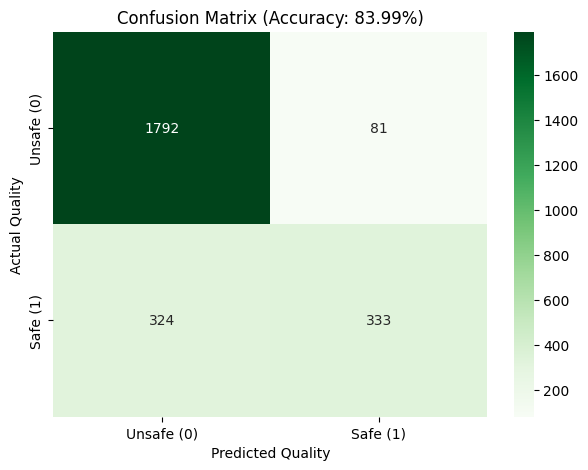


Generating predictions for new data...

📝 PREDICTION RESULTS (TOP 10)
   Sample ID  Status  Safety_Score
0          1  Unsafe      0.336806
1          2  Unsafe      0.216973
2          3  Unsafe      0.095500
3          4  Unsafe      0.124976
4          5  Unsafe      0.275065
5          6  Unsafe      0.418239
6          7  Unsafe      0.053398
7          8  Unsafe      0.437081
8          9  Unsafe      0.093333
9         10  Unsafe      0.222761

🚀 Success! File saved to: C:\Users\kavee\Downloads\New_Data_Predictions.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==========================================
# 1. SETUP PATHS
# ==========================================
TRAIN_DATA_PATH = r"C:\Users\kavee\Downloads\codemerged_dataset.csv" 
NEW_DATA_PATH   = r"C:\Users\kavee\Downloads\Water Quality Testing.csv"
OUTPUT_PATH     = r"C:\Users\kavee\Downloads\New_Data_Predictions.csv"

# Load Datasets
print("Loading datasets...")
try:
    df_train = pd.read_csv(TRAIN_DATA_PATH)
    df_new = pd.read_csv(NEW_DATA_PATH)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# ==========================================
# 2. ALIGN FEATURES
# ==========================================
column_mapping = {
    "Dissolved Oxygen (mg/L)": "DO",
    "Conductivity (µS/cm)": "Conductivity",
    "Turbidity (NTU)": "Turbidity",
    "Temperature (°C)": "Temperature" 
}
df_new = df_new.rename(columns=column_mapping)

train_cols = set(df_train.columns)
new_cols = set(df_new.columns)
exclude_cols = {"Sample ID", "Potability", "Status"}
common_features = list((train_cols.intersection(new_cols)) - exclude_cols)

print(f"\nTraining Model using ONLY: {common_features}")

# ==========================================
# 3. PREPARE & SPLIT DATA
# ==========================================
X = df_train[common_features]
y = df_train["Potability"]

X_new_raw = df_new[common_features].copy()
for col in common_features:
    X_new_raw[col] = pd.to_numeric(X_new_raw[col], errors='coerce')

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================
# 4. IMPUTATION
# ==========================================
print("Imputing missing values...")
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=common_features)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=common_features)
X_new_imputed = pd.DataFrame(imputer.transform(X_new_raw), columns=common_features)

# ==========================================
# 5. TRAIN & EVALUATE (With Confusion Matrix)
# ==========================================
print("Training Random Forest...")
model = RandomForestClassifier(n_estimators=300, random_state=42, min_samples_split=5)
model.fit(X_train_imputed, y_train)

y_val_pred = model.predict(X_val_imputed)
acc = accuracy_score(y_val, y_val_pred)

print("\n" + "="*40)
print(f"📊 PERFORMANCE SUMMARY")
print("="*40)
print(f"✅ Validation Accuracy: {acc:.2%}")
print("-" * 40)
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Plotting Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Unsafe (0)', 'Safe (1)'], 
            yticklabels=['Unsafe (0)', 'Safe (1)'])
plt.title(f'Confusion Matrix (Accuracy: {acc:.2%})')
plt.ylabel('Actual Quality')
plt.xlabel('Predicted Quality')
plt.show()

# ==========================================
# 6. PREDICT ON NEW DATA & SAVE
# ==========================================
print("\nGenerating predictions for new data...")
df_new["Predicted_Potability"] = model.predict(X_new_imputed)
df_new["Safety_Score"] = model.predict_proba(X_new_imputed)[:, 1]
df_new["Status"] = df_new["Predicted_Potability"].map({1: "Safe", 0: "Unsafe"})

print("\n" + "="*40)
print("📝 PREDICTION RESULTS (TOP 10)")
print("="*40)
print(df_new[["Sample ID", "Status", "Safety_Score"]].head(10))

df_new.to_csv(OUTPUT_PATH, index=False)
print(f"\n🚀 Success! File saved to: {OUTPUT_PATH}")

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
# Update paths
TRAIN_DATA_PATH = r"C:\Users\kavee\Downloads\codemerged_dataset.csv"
NEW_DATA_PATH   = r"C:\Users\kavee\Downloads\Water Quality Testing.csv"
OUTPUT_PATH     = r"C:\Users\kavee\Downloads\New_Data_Predictions_Cleaned.csv"

# ⚙️ SETTING: Maximum allowed missing data (0.4 = 40%)
# Features with more missing values than this will be dropped.
MISSING_THRESHOLD = 0.4 

print("Loading datasets...")
try:
    df_train = pd.read_csv(TRAIN_DATA_PATH)
    df_new = pd.read_csv(NEW_DATA_PATH)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# ==========================================
# 2. FILTER BAD FEATURES (High Missingness)
# ==========================================
print("\n--- Feature Quality Check ---")

# Calculate missing percentage for each column
missing_percent = df_train.isnull().mean()
drop_cols = missing_percent[missing_percent > MISSING_THRESHOLD].index.tolist()

print(f"Checking for features with > {MISSING_THRESHOLD*100}% missing values...")
if drop_cols:
    print(f"❌ DROPPING these columns (too empty): {drop_cols}")
    df_train = df_train.drop(columns=drop_cols)
else:
    print("✅ All features are good (missing values are below threshold).")

# ==========================================
# 3. ALIGN FEATURES (Train vs New Data)
# ==========================================
# Rename New Data columns to match Train Data
column_mapping = {
    "Dissolved Oxygen (mg/L)": "DO",
    "Conductivity (µS/cm)": "Conductivity",
    "Turbidity (NTU)": "Turbidity"
}
df_new = df_new.rename(columns=column_mapping)

# Find Common Features
train_cols = set(df_train.columns)
new_cols = set(df_new.columns)
exclude = {"Sample ID", "Potability", "Status"}

# Intersection of: [Good Training Features] AND [Available New Features]
common_features = list((train_cols.intersection(new_cols)) - exclude)

if not common_features:
    print("\n❌ ERROR: No common features left after cleaning! Increase the MISSING_THRESHOLD.")
    exit()

print(f"\n✅ Final Features used for Model: {common_features}")

# ==========================================
# 4. PREPARE DATA & PREVENT LEAKAGE
# ==========================================
X = df_train[common_features]
y = df_train["Potability"]

X_new_raw = df_new[common_features]
# Ensure numeric
for col in common_features:
    X_new_raw[col] = pd.to_numeric(X_new_raw[col], errors='coerce')

# Split BEFORE Imputation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================
# 5. IMPUTE & TRAIN
# ==========================================
print("\nImputing and Training...")
imputer = KNNImputer(n_neighbors=5)

# Fit imputer on Training data ONLY
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=common_features)
X_val_imputed   = pd.DataFrame(imputer.transform(X_val), columns=common_features)
X_new_imputed   = pd.DataFrame(imputer.transform(X_new_raw), columns=common_features)

# Train Model
model = RandomForestClassifier(n_estimators=300, random_state=42, min_samples_split=5)
model.fit(X_train_imputed, y_train)

# ==========================================
# 6. EVALUATE & PREDICT
# ==========================================
# Validation Accuracy
y_val_pred = model.predict(X_val_imputed)
acc = accuracy_score(y_val, y_val_pred)
print(f"📊 Model Accuracy (on cleaned feature set): {acc:.4f}")

# Predict on New Data
df_new["Predicted_Potability"] = model.predict(X_new_imputed)
df_new["Safety_Score"] = model.predict_proba(X_new_imputed)[:, 1]
df_new["Status"] = df_new["Predicted_Potability"].map({1: "Safe", 0: "Unsafe"})

# Save
df_new.to_csv(OUTPUT_PATH, index=False)
print(f"\n🚀 Predictions saved to: {OUTPUT_PATH}")
print(df_new[["Sample ID", "Status", "Safety_Score"]].head())

Loading datasets...

--- Feature Quality Check ---
Checking for features with > 40.0% missing values...
✅ All features are good (missing values are below threshold).

✅ Final Features used for Model: ['DO', 'Conductivity', 'Turbidity', 'pH']

Imputing and Training...


C:\Users\kavee\AppData\Local\Temp\ipykernel_26960\2007034300.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new_raw[col] = pd.to_numeric(X_new_raw[col], errors='coerce')


📊 Model Accuracy (on cleaned feature set): 0.8399

🚀 Predictions saved to: C:\Users\kavee\Downloads\New_Data_Predictions_Cleaned.csv
   Sample ID  Status  Safety_Score
0          1  Unsafe      0.336806
1          2  Unsafe      0.216973
2          3  Unsafe      0.095500
3          4  Unsafe      0.124976
4          5  Unsafe      0.275065


Test 3 :- Lakeoxygen


In [2]:
import pandas as pd
import numpy as np
import os  # Added to check paths
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score

# ==========================================
# 1. SETUP PATHS
# ==========================================
TRAIN_DATA_PATH = r"C:\Users\kavee\Downloads\codemerged_dataset.csv"
NEW_DATA_PATH = r"C:\Users\kavee\Downloads\codelakeoxygen_clean.csv"
OUTPUT_PATH = r"C:\Users\kavee\Downloads\Lake_Water_Predictions.csv"

# --- PATH VALIDATION ---
files_exist = True
if not os.path.exists(TRAIN_DATA_PATH):
    print(f"❌ MISSING FILE: {TRAIN_DATA_PATH}")
    files_exist = False
if not os.path.exists(NEW_DATA_PATH):
    print(f"❌ MISSING FILE: {NEW_DATA_PATH}")
    files_exist = False

if not files_exist:
    print("\n⚠️ Please fix the file paths above before running the rest of the code.")
else:
    print("✅ Files found! Proceeding...")
    
    # Load Data
    df_train = pd.read_csv(TRAIN_DATA_PATH)
    df_new = pd.read_csv(NEW_DATA_PATH)

    # ==========================================
    # 2. ALIGN COLUMNS
    # ==========================================
    column_mapping = {"Cond": "Conductivity", "Temp": "Temperature", "DOsat": "DO_Saturation"}
    df_new = df_new.rename(columns=column_mapping)

    # ==========================================
    # 3. IDENTIFY COMMON FEATURES
    # ==========================================
    MISSING_THRESHOLD = 0.4
    missing_percent = df_train.isnull().mean()
    drop_cols = missing_percent[missing_percent > MISSING_THRESHOLD].index.tolist()
    df_train = df_train.drop(columns=drop_cols)

    df_train.columns = df_train.columns.str.strip()
    df_new.columns = df_new.columns.str.strip()

    train_cols = set(df_train.columns)
    new_cols = set(df_new.columns)
    exclude = {"Sample ID", "Potability", "Status", "Date.Time", "Depth", "DO_Saturation", "Temperature"}
    common_features = list((train_cols.intersection(new_cols)) - exclude)

    print(f"✅ Features used: {common_features}")

    # ==========================================
    # 4. PREPARE, TRAIN & PREDICT
    # ==========================================
    X = df_train[common_features].copy()
    y = df_train["Potability"].dropna()
    X = X.loc[y.index] # Ensure X and y match after dropping NaNs

    X_new_raw = df_new[common_features].copy()

    for col in common_features:
        X[col] = pd.to_numeric(X[col], errors='coerce')
        X_new_raw[col] = pd.to_numeric(X_new_raw[col], errors='coerce')

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Imputing and Training...")
    imputer = KNNImputer(n_neighbors=5)
    X_train_imp = imputer.fit_transform(X_train)
    X_val_imp = imputer.transform(X_val)
    X_new_imp = imputer.transform(X_new_raw)

    model = RandomForestClassifier(n_estimators=300, random_state=42)
    model.fit(X_train_imp, y_train)

    # Results
    df_new["Predicted_Potability"] = model.predict(X_new_imp)
    df_new["Status"] = df_new["Predicted_Potability"].map({1: "Safe", 0: "Unsafe"})
    
    df_new.to_csv(OUTPUT_PATH, index=False)
    print(f"🚀 Success! Results saved to {OUTPUT_PATH}")

✅ Files found! Proceeding...


EmptyDataError: No columns to parse from file